I have been listening to 21 pilots for past 4-5 years. Their songs provide me motivation to just go through my day. They have a huge fan base. Some songs do resonate with some people more than others. In this project, I hope to analyze various factors that affect the popularity of a 21 pilots album track.

To my luck, spotify provides a structured api to fetch details about almost any artist. Along with that, it also keeps track of features like *danceability*, *energy* etc. for each track. We are going to see which of those features contribute the most towards the popularity of a track. This result will be indicative of which factors resonate more with the fan base of 21 pilots, and can even help describe certain attributes about the fans themselves.

In [4]:
import pandas as pd
import numpy as np
import sklearn
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import configparser

In [1]:
#Open source python library for Spotify API
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

Register your app/script with spotify. You'll recieve two credentials:
1. Client ID
2. Client Secret

Both of these are used by spotipy for authenticating our app with Spotify, so that it can establish a session for us to make API calls.

In [9]:
config = configparser.ConfigParser()
config.read('spotify_credentials.ini')
client_id = config['Client Cred']['client_id']
client_secret = config['Client Cred']['client_secret']
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

The spotify id of an artist is mentioned on their spotify page.

In [13]:
# get all track ids of 21 pilots
# Fetch the artist by ID
tp_id = '3YQKmKGau1PzlVlkL1iodx'
tp_albums =  sp.artist_albums(tp_id)

# Fetch id of all tracks in each album
track_ids = {}
for album in tp_albums['items']:
    for track in sp.album_tracks(album['id'])['items']:
        track_ids[track['id']] = [[]]

track_ids_list = [key for key in track_ids]
num_tracks = len(track_ids_list)

In [14]:
# For each id in track_ids, fetch popularity
count = 0
while(count < num_tracks):
    # Because of Spotify's rate limit, can't fetch more than 50 tracks at once
    last_index = min(count+50, num_tracks)
    for track in sp.tracks(track_ids_list[count:last_index])['tracks']:
        if track['id'] in track_ids:
            track_ids[track['id']].append(track['popularity'])
    count += (last_index - count)

Now, we need to associate each soundtrack with some features. Luckily, spotify already keeps track a bunch of human readable features for each song. So our task is cut short to just fetching those features. We would want to find a subset of those features which the popularity most depends on.

In [20]:
features = ['duration_ms', 'key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy',
            'instrumentalness','liveness', 'loudness', 'speechiness', 'valence', 'tempo']

In [18]:
#Fetch features for each track
count = 0

while(count < num_tracks):
    #Can't ask for more than 100 tracks at once
    last_index = min(count+100, num_tracks)
    tracks_features = sp.audio_features(track_ids_list[count:last_index])
    for i in range(len(tracks_features)):
        track = tracks_features[i]
        if track['id'] in track_ids:
            for idx in range(len(features)):
                track_ids[track['id']][0].append(track[features[idx]])
    count += (last_index - count)

In [19]:
# Let's view all the data
print(features)
print(track_ids_list)
for key in track_ids:
    print(track_ids[key])
    break

['duration_ms', 'key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']
['1E1uGhNdBe6Dddbgs2KqtZ', '2uBhGx3m5iJrtsql8Qk00j', '01vv2AjxgP4uUyb8waYO5Y', '5HeKOKc4phmLn8e4I7EkzD', '23OXdR7YuUBVWh5hSnYJau', '5G6Gt9RtNaeIE418pd4yre', '0sXvjZV7p4uvyPN4uQo3FH', '7I3skNaQdvZSS7zXY2VHId', '5SehvGGC53A7SZKCLXQcyt', '6gFtgkh8ShkrJn52Cbdhxy', '5INKIG4QNuD4xq7qZcfPzp', '7daBwTiPNOVgoMUG4SICgh', '1CDVadnneswMxi6gBqJTtC', '5HCXMBxZIVaVLXpyoqPM3g', '7i9763l5SSfOnqZ35VOcfy', '3CRDbSIZ4r5MsZ0YwxuEkn', '2Z8WuEywRWYTKe1NybPQEW', '1s9xuJxhYM0LdVqksjegcg', '3bnVBN67NBEzedqQuWrpP4', '2P61EK6DMGyVyssLWS4fKy', '1lguQJjlNrIOoOylYVZN3M', '57yL3161hUMuw06zzzUCHi', '6GmkJJMe9U1tEcrJ3Hq3A1', '22OqansuvEMQu9W0EfiGTI', '4Oyl6oYSNeeZZP0OAxPVaU', '40sRwFjfrRnaTdYPJIg4CP', '7qxjGHW485TL8ciwkHD5MK', '5P3yUXUC9rZPJPNmYGKEAz', '2azva9Vt0rHb5rd57GtlBv', '7DpvxBL8Q02CV46scd6Dqm', '1TsxL6nhuECZssktA8qcoI', '7JkAQU7rL2rtmwv92YVnlE

In [21]:
features_2d = []
popularities = []
for k in track_ids:
    features_2d.append(track_ids[k][0])
    popularities.append(track_ids[k][1])

In [22]:
# Convert into pandas dataframe
x = pd.DataFrame(features_2d, columns=features)
y = pd.DataFrame(popularities)
print(x.head())
print(y.head())

   duration_ms  key  mode  time_signature  acousticness  danceability  energy  \
0       238560   11     0               4       0.00849         0.620   0.610   
1       145947    6     0               4       0.08570         0.700   0.934   
2       258853    8     0               4       0.07470         0.734   0.607   
3       229120    1     1               4       0.05630         0.749   0.723   
4       324467   10     0               4       0.07350         0.609   0.674   

   instrumentalness  liveness  loudness  speechiness  valence    tempo  
0          0.162000    0.2050    -8.329       0.0373    0.235  127.052  
1          0.226000    0.1140    -5.941       0.1700    0.224   92.973  
2          0.000577    0.0968    -7.249       0.0806    0.518   90.023  
3          0.022000    0.0977    -6.609       0.0432    0.674  108.999  
4          0.060000    0.3450    -7.388       0.0548    0.315   90.009  
    0
0  71
1  64
2  66
3  71
4  77


In [25]:
# Analyze data: 
print(x.describe())
np.where(pd.isnull(x))

         duration_ms         key        mode  time_signature  acousticness  \
count     139.000000  139.000000  139.000000      139.000000    139.000000   
mean   234551.611511    5.618705    0.661871        3.956835      0.234895   
std     68297.144315    3.537369    0.474784        0.396918      0.273546   
min     28788.000000    0.000000    0.000000        1.000000      0.000163   
25%    210180.000000    2.000000    0.000000        4.000000      0.043700   
50%    239015.000000    6.000000    1.000000        4.000000      0.110000   
75%    270528.000000    9.000000    1.000000        4.000000      0.321500   
max    370808.000000   11.000000    1.000000        5.000000      0.994000   

       danceability      energy  instrumentalness    liveness    loudness  \
count    139.000000  139.000000        139.000000  139.000000  139.000000   
mean       0.649540    0.584485          0.006818    0.199347   -8.882281   
std        0.113266    0.235881          0.026566    0.163215    6

(array([], dtype=int64), array([], dtype=int64))

In [57]:
# Let's scale the features first
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

all_cols = x.columns
minmax_cols_zero_one = pd.Index(['acousticness','danceability','mode','energy','instrumentalness','liveness',
             'speechiness','valence'])
minmax_cols_others = pd.Index(['key'])
std_cols = all_cols.difference(minmax_cols_zero_one).difference(minmax_cols_others)
x_std = x[std_cols]
x_zero_one = x[minmax_cols_zero_one]
x_others = x[minmax_cols_others]
# minmax - (0..1) (0..1) (0/1)  (-1,0,1,....,11) (0..1) (0..1)
# (0..1) (0..1) (0..1) 
# Now scale
scaler = StandardScaler().fit(x_std)
x_std_scaled = scaler.transform(x_std)

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(x_zero_one)
x_zero_one_scaled = min_max_scaler.transform(x_zero_one)

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 11)).fit(x_others)
x_others_scaled = min_max_scaler.transform(x_others)

# Now merge all the scaled parts
print(x_std_scaled[0:2])
print(x_others_scaled[0:2])
print(x_zero_one_scaled[0:2])

[[ 0.05890269  0.08848285  0.3365431   0.10914504]
 [-1.30203194  0.4703814  -0.91517997  0.10914504]]
[[11.        ]
 [ 5.54545455]]
[[0.00837864 0.64052288 0.         0.6421928  0.71681416 0.18727915
  0.0126406  0.17997989]
 [0.08606743 0.77124183 0.         0.99671737 1.         0.07243816
  0.15479379 0.16769076]]


In [48]:
x_scaled = np.concatenate((x_std_scaled, x_others_scaled, x_zero_one_scaled), axis=1)
x_scaled_df = pd.DataFrame(x_scaled)

In [52]:
x_scaled_df.columns = std_cols.append(minmax_cols_others).append(minmax_cols_zero_one)

In [56]:
x_scaled_df.head(10)

,duration_ms,loudness,tempo,time_signature,key,acousticness,danceability,mode,energy,instrumentalness,liveness,speechiness,valence
0,0.058903,0.088483,0.336543,0.109145,11.000000,0.008379,0.640523,0.0,0.642193,0.716814,0.187279,0.012641,0.179980
1,-1.302032,0.470381,-0.915180,0.109145,5.545455,0.086067,0.771242,0.0,0.996717,1.000000,0.072438,0.154794,0.167691
2,0.357105,0.261201,-1.023534,0.109145,7.727273,0.074999,0.826797,0.0,0.638910,0.002553,0.050732,0.059025,0.496146
3,-0.079817,0.363552,-0.326544,0.109145,0.090909,0.056485,0.851307,1.0,0.765839,0.097345,0.051868,0.018961,0.670428
4,1.321294,0.238971,-1.024048,0.109145,9.909091,0.073792,0.622549,0.0,0.712222,0.265487,0.363958,0.031387,0.269355
5,-0.845125,0.200750,1.216889,0.109145,5.545455,0.297672,0.875817,1.0,0.574352,0.000045,0.025618,0.122657,0.497263
6,0.083987,-0.152203,1.159223,-2.419382,11.000000,0.381186,0.820261,0.0,0.441952,0.001367,0.041267,0.120514,0.355379
7,0.452916,0.437117,-1.133871,0.109145,8.818182,0.010401,0.493464,1.0,0.867600,0.002699,0.406865,0.026567,0.331918
8,-0.139772,0.181399,0.815099,0.109145,8.818182,0.070169,0.816993,0.0,0.633439,0.000031,0.329884,0.170862,0.283879
9,0.706255,0.483975,-0.218595,0.109145,3.363636,0.120580,0.674837,1.0,0.588576,0.009292,0.380363,0.010712,0.674897


In [60]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 100)).fit(y)
y_scaled = min_max_scaler.transform(y)
y_scaled_df = pd.DataFrame(y_scaled)
y_scaled_df.head()

,0
0,85.365854
1,76.829268
2,79.268293
3,85.365854
4,92.682927


In [80]:
y_scaled_df.columns = pd.Index(['Popularity'])

In [61]:
# Visualizations -- violin plot, box plot, heatmap
print(x_scaled_df.describe())
print(y_scaled_df.describe())

        duration_ms      loudness         tempo  time_signature         key  \
count  1.390000e+02  1.390000e+02  1.390000e+02    1.390000e+02  139.000000   
mean  -1.789136e-16  1.789136e-16  2.044727e-16    4.392969e-16    5.129496   
std    1.003617e+00  1.003617e+00  1.003617e+00    1.003617e+00    3.858948   
min   -3.023666e+00 -3.221784e+00 -2.327156e+00   -7.476436e+00   -1.000000   
25%   -3.581373e-01  2.075503e-02 -9.370343e-01    1.091450e-01    1.181818   
50%    6.558885e-02  3.579548e-01  7.763304e-02    1.091450e-01    5.545455   
75%    5.286678e-01  5.108422e-01  6.844317e-01    1.091450e-01    8.818182   
max    2.002268e+00  8.434841e-01  2.061643e+00    2.637672e+00   11.000000   

       acousticness  danceability        mode      energy  instrumentalness  \
count    139.000000    139.000000  139.000000  139.000000        139.000000   
mean       0.236188      0.688790    0.661871    0.614274          0.030169   
std        0.275242      0.185076    0.474784    0.

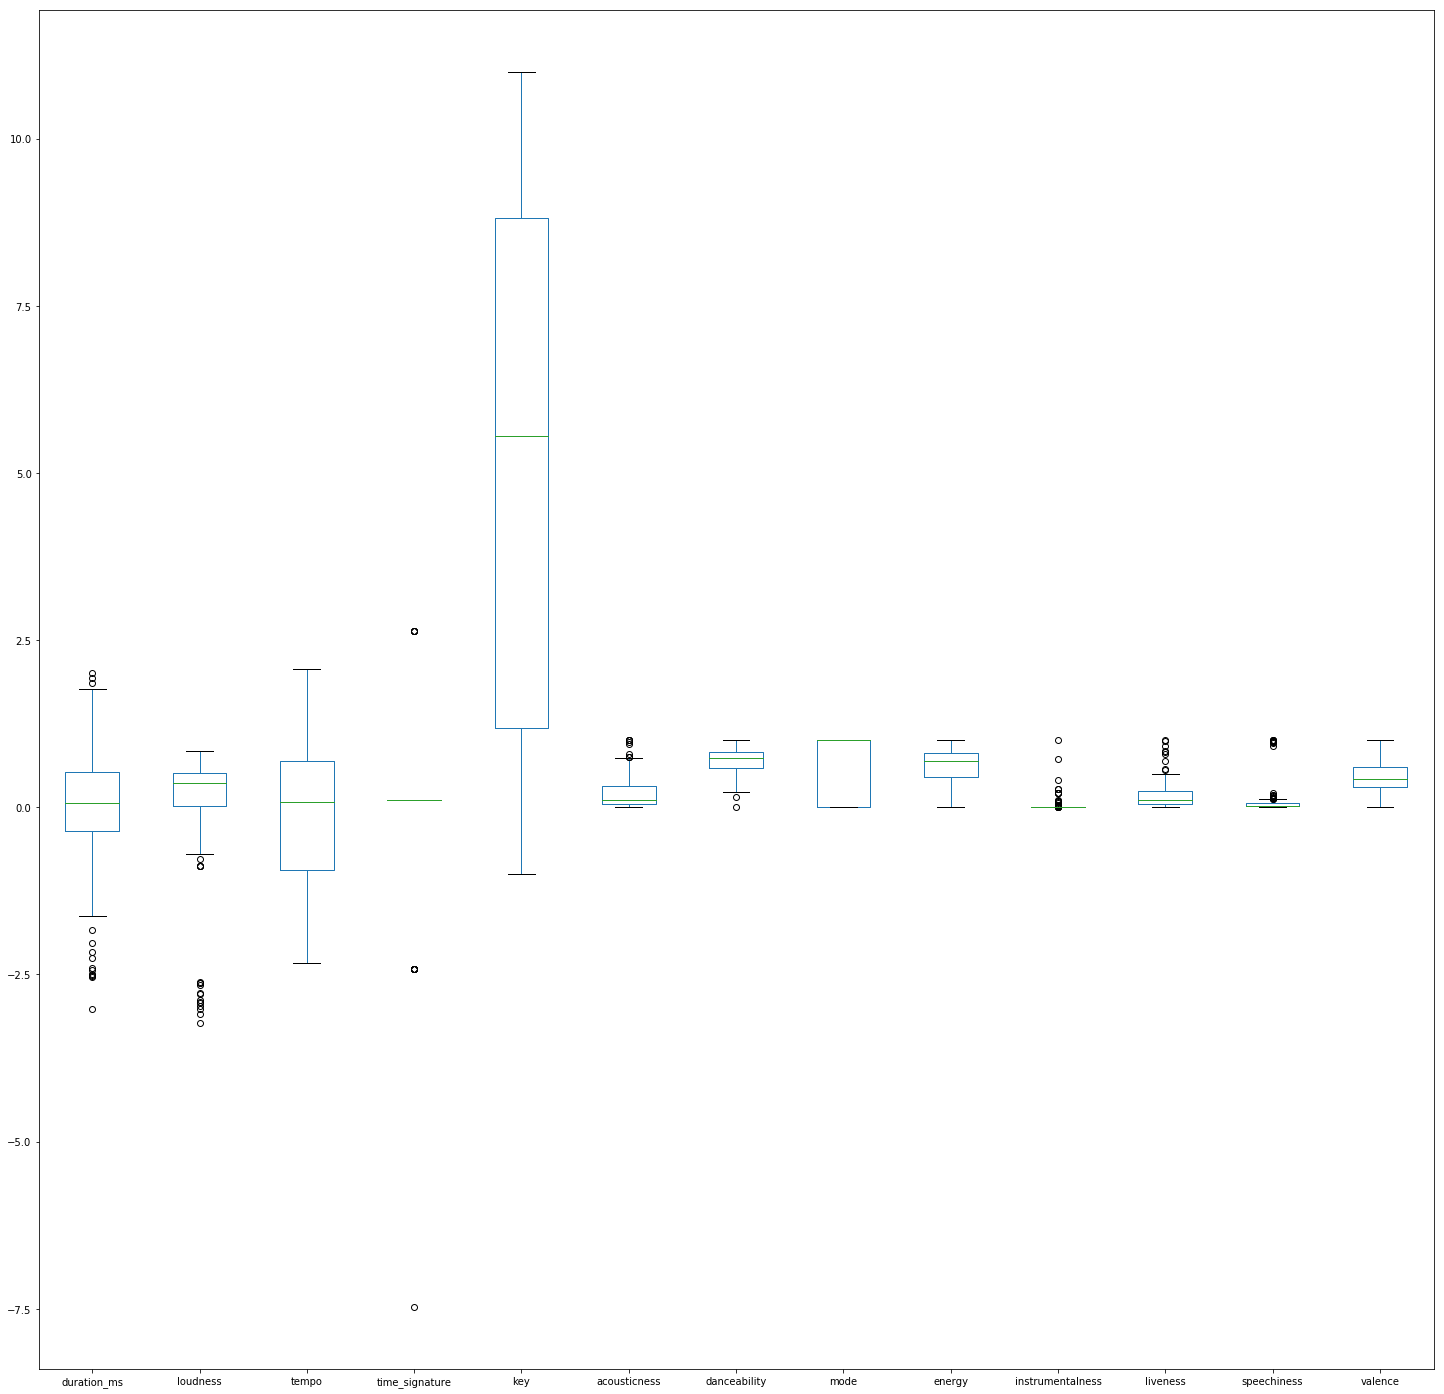

In [66]:
%matplotlib inline
x_scaled_df.plot(kind='box', figsize=(25,25))
#https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

In [68]:
!pip install seaborn

     |████████████████████████████████| 283 kB 1.1 MB/s eta 0:00:01


In [70]:
print(np.random.rand(10, 12))

[[0.28262074 0.34370187 0.86860628 0.67888449 0.75150053 0.74764194
  0.79966607 0.07288922 0.02801593 0.28089449 0.4738907  0.84210897]
 [0.3568058  0.20950701 0.58385991 0.04556975 0.5610633  0.04102793
  0.13192282 0.87532825 0.20337839 0.71975558 0.03931425 0.70696122]
 [0.33698215 0.82850657 0.86702809 0.55543675 0.03693942 0.06853481
  0.35487661 0.1891525  0.20433046 0.96286135 0.89900814 0.30865817]
 [0.26190497 0.94443777 0.34410229 0.39960857 0.7027481  0.36777613
  0.13971094 0.52250066 0.42294126 0.03978621 0.66769517 0.63473458]
 [0.72762318 0.37353836 0.38011388 0.51720231 0.12048475 0.0051864
  0.11217449 0.76063049 0.07492871 0.62047998 0.19874337 0.5485242 ]
 [0.39692491 0.69320855 0.82474404 0.21695625 0.82994224 0.72030253
  0.84396774 0.870257   0.03654447 0.66148588 0.43222553 0.173043  ]
 [0.99886542 0.61440122 0.45415685 0.15079795 0.82570125 0.62250061
  0.23235394 0.00702944 0.30119471 0.48600925 0.29810978 0.12682784]
 [0.6793526  0.05705177 0.19923634 0.64948

In [89]:
correlation_matrix = pd.concat([x_scaled_df,y_scaled_df],axis=1).corr()
correlation_matrix.head()

,duration_ms,loudness,tempo,time_signature,key,acousticness,danceability,mode,energy,instrumentalness,liveness,speechiness,valence,Popularity
duration_ms,1.000000,0.647884,0.253215,-0.050438,0.150900,-0.596520,-0.248014,-0.054152,0.502262,-0.035233,-0.175833,-0.697245,-0.240559,0.069270
loudness,0.647884,1.000000,0.353896,0.055586,-0.049700,-0.700134,-0.056822,-0.051003,0.776926,-0.003894,-0.387879,-0.909591,0.127516,0.286654
tempo,0.253215,0.353896,1.000000,-0.044299,-0.118687,-0.246471,-0.116059,0.126158,0.339923,-0.066154,-0.132113,-0.269943,0.015977,0.032759
time_signature,-0.050438,0.055586,-0.044299,1.000000,-0.099546,-0.059975,0.059676,0.075798,0.073134,0.024556,0.101250,-0.030809,0.158438,-0.069414
key,0.150900,-0.049700,-0.118687,-0.099546,1.000000,0.012776,-0.130009,-0.258537,-0.121140,0.141416,0.031320,-0.001065,-0.175685,-0.052930


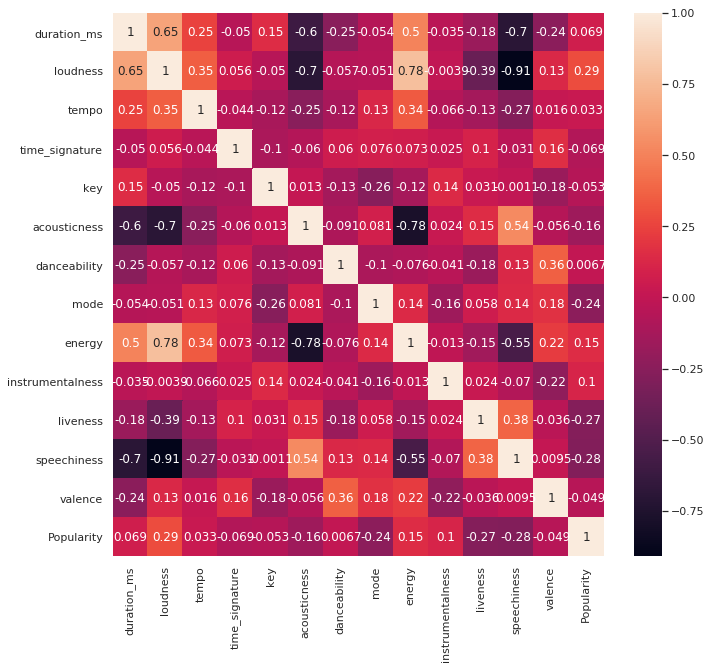

In [86]:
# Heamap
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
plt.figure(figsize=(11,10))
ax = sns.heatmap(correlation_matrix, annot=True)

In [94]:
most_correlated = np.where(abs(correlation_matrix) > 0.7)
for x,y in zip(most_correlated[0],most_correlated[1]):
    if(x!=y and x!=len(correlation_matrix.columns)-1 and y!=len(correlation_matrix.columns)-1):
        print(correlation_matrix.columns[x],correlation_matrix.index[y])

loudness acousticness
loudness energy
loudness speechiness
acousticness loudness
acousticness energy
energy loudness
energy acousticness
speechiness loudness


In [99]:
most_correlated = np.where(abs(correlation_matrix) < 0.01)
for x,y in zip(most_correlated[0],most_correlated[1]):
    if(x!=y and (x==len(correlation_matrix.columns)-1 or y==len(correlation_matrix.columns)-1)):
        print(correlation_matrix.columns[x],correlation_matrix.index[y])

danceability Popularity
Popularity danceability


1. Acousticness, loudness and energy are a lot related, which is common sensical.
2. We can discard danceability for popularity

In [106]:
correlation_matrix['Popularity'].iloc[:-1].idxmax()

'loudness'

In [107]:
correlation_matrix['Popularity'].iloc[:-1].idxmin()

'speechiness'

In [108]:
abs(correlation_matrix['Popularity'].iloc[:-1]).idxmin()

'danceability'

**Conclusion**
1. An overall 'loud' 21 pilots track usually is more popular
2. An overall speechy/wordy 21 pilots track usually is least popular
3. The 21 pilots fan base doesn't care whether or not a track calls for some dance moves.